In [1]:
import matplotlib.pyplot as plt
from subprocess import check_output
import matplotlib as mpl
import numpy as np
import pyvista as pv
from myusefultools import parser
from phydrus.read import read_nod_inf

REPO_PATH = check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')


## Read HYDRUS-1D results

Using the `phydrus` package. Remember to check the units! 

In [2]:
HYDRUS_NOD_INF = "HYDRUS_RESULTS/Nod_Inf.out"
hydrus_profiles = read_nod_inf("HYDRUS_RESULTS/Nod_Inf.out")

# Remove time zero
del hydrus_profiles[0.0]

hydrus_times_hours = hydrus_profiles.keys()
print("The following times were found \n", hydrus_times_hours)


The following times were found 
 dict_keys([2.0, 4.0, 6.0, 8.0, 10.0, 12.0])


In [3]:
hydrus_profiles[12.0]

,Node,Depth,Head,Moisture,K,C,Flux,Sink,Kappa,v/KsTop,Temp
1,1,0.0,5.000,0.4100,14.590000,0.000000,-14.720000,0.0,-1,-1.010000,20.0
2,2,-5.0,4.956,0.4100,14.590000,0.000000,-14.720000,0.0,-1,-1.010000,20.0
3,3,-10.0,4.912,0.4100,14.590000,0.000000,-14.720000,0.0,-1,-1.010000,20.0
4,4,-15.0,4.868,0.4100,14.590000,0.000000,-14.720000,0.0,-1,-1.010000,20.0
5,5,-20.0,4.823,0.4100,14.590000,0.000000,-14.720000,0.0,-1,-1.010000,20.0
...,...,...,...,...,...,...,...,...,...,...,...
117,117,-580.0,-4.683,0.3630,4.402000,0.018750,-11.230000,0.0,-1,-0.770000,20.0
118,118,-585.0,-17.693,0.1754,0.057520,0.007313,-4.111000,0.0,-1,-0.282000,20.0
119,119,-590.0,-45.429,0.0952,0.000553,0.001055,-0.095370,0.0,-1,-0.006540,20.0
120,120,-595.0,-46.293,0.0943,0.000503,0.001013,-0.000561,0.0,-1,-0.000038,20.0


In [4]:
## Sample colors for plot
cmap = mpl.cm.tab20c
colors = cmap(np.linspace(0, 1, len(hydrus_times_hours)))

## Read OpenFOAM results

Using `pyvista` to generate profiles by sampling over line. Remember to check the printed times! 

In [5]:
OPENFOAM_FOLDER = "LOAMYSAND"
of_vtk_files = parser.getVTKList(f"{OPENFOAM_FOLDER}/VTK")
of_times_seconds = parser.getTimeList(OPENFOAM_FOLDER)
of_times_hours = np.array([float(t)/3600 for t in of_times_seconds])
print("The following times were found \n", of_times_hours)

The following times were found 
 [ 2.00571806  4.00571806  6.00571806  8.00571806 10.00571806 12.00571806]


In [6]:
for vtk, time_s, time_hr in zip(of_vtk_files, of_times_seconds, of_times_hours):
    print(vtk, time_s, time_hr)

LOAMYSAND_148.vtk 7220.585 2.0057180555555556
LOAMYSAND_268.vtk 14420.585 4.005718055555556
LOAMYSAND_388.vtk 21620.585 6.005718055555556
LOAMYSAND_508.vtk 28820.585 8.005718055555555
LOAMYSAND_628.vtk 36020.585 10.005718055555555
LOAMYSAND_748.vtk 43220.585 12.005718055555555


In [7]:
len(hydrus_profiles) == len(of_vtk_files) == len(colors)

True

In [8]:
COLUMN_LENGTH = 6.00 # m
POROSITY = 0.41

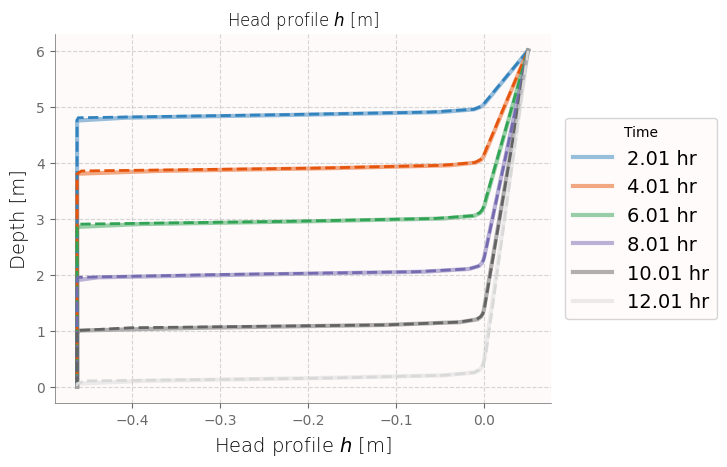

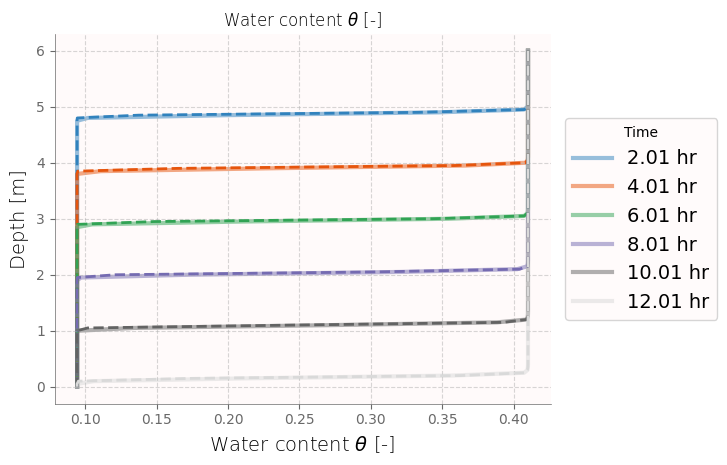

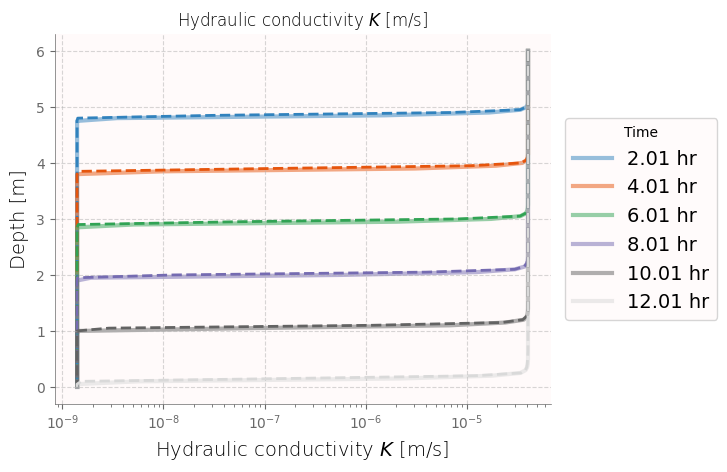

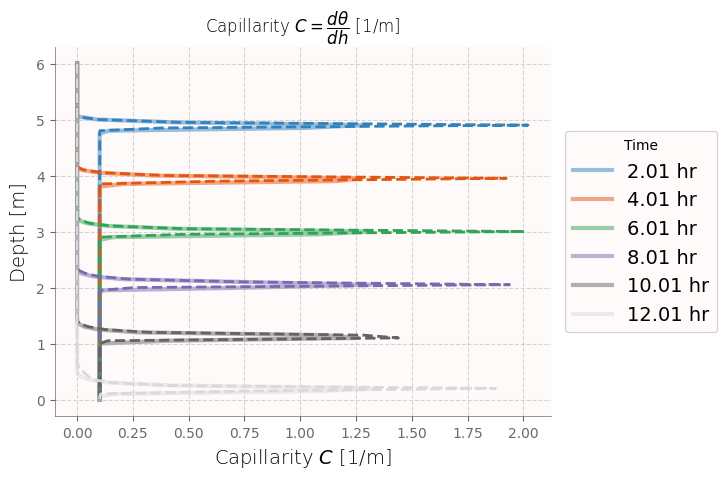

In [9]:
fig_head ,ax_head = plt.subplots()
fig_theta ,ax_theta = plt.subplots()
fig_K ,ax_K = plt.subplots()
fig_capil ,ax_capil = plt.subplots()


for (time_hydrus, hydrus_profile), time_of, of_vtk, color in zip(hydrus_profiles.items(), of_times_hours, of_vtk_files, colors):

    mesh = pv.read(f"{OPENFOAM_FOLDER}/VTK/" + of_vtk)
    line = pv.Line(
    a:=[0, 0, mesh.bounds[5]],
    b:=[0, 0, mesh.bounds[2]])
    
    sample = mesh.sample_over_line(a,b)

    # Head ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##  OpenFOAM results    
    ax_head.plot(
        sample["h"],                #<- Head  (m)
        sample.points[:, 2],        #<- Depth (m)
        label=f"{time_of:.2f} hr",
        c=color, lw=3, alpha=0.5, zorder=1
    )

    ##  Hydrus1D results    
    ax_head.plot(
        hydrus_profile["Head"]/100,  #<- Head (m)
        COLUMN_LENGTH + hydrus_profile["Depth"]/100, #<- Depth (m)
        c=color, ls='dashed', zorder=2
    ) 

    # Water content ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##  OpenFOAM results    
    ax_theta.plot(
        sample["Sw"] * POROSITY,      #<- theta = Sw * porosity
        sample.points[:, 2],          #<- Depth (m)
        label=f"{time_of:.2f} hr",
        c=color, lw=3, alpha=0.5, zorder=1
    )

    ##  Hydrus1D results    
    ax_theta.plot(
        hydrus_profile["Moisture"],  #<- Theta (m)
        COLUMN_LENGTH + hydrus_profile["Depth"]/100, #<- Depth (m)
        c=color, ls='dashed', zorder=2
    )

    # Hydraulic conduct ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##  OpenFOAM results    
    ax_K.plot(
        sample["hydraulicCond"],      #<- K (m/s)
        sample.points[:, 2],          #<- Depth (m)
        label=f"{time_of:.2f} hr",
        c=color, lw=3, alpha=0.5, zorder=1
    )

    ##  Hydrus1D results    
    ax_K.plot(
        hydrus_profile["K"]/(100*3600),  #<- K (m/s)
        COLUMN_LENGTH + hydrus_profile["Depth"]/100, #<- Depth (m)
        c=color, ls='dashed', zorder=2
    )

    # Capillarity ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##  OpenFOAM results    
    ax_capil.plot(
        sample["capillarity"] * POROSITY,   #<- C(h) (1/m)
        sample.points[:, 2],                #<- Depth (m)
        label=f"{time_of:.2f} hr",
        c=color, lw=3, alpha=0.5, zorder=1
    )

    ##  Hydrus1D results    
    ax_capil.plot(
        hydrus_profile["C"] * 100,  #<- C(h) (m/s)
        COLUMN_LENGTH + hydrus_profile["Depth"]/100, #<- Depth (m)
        c=color, ls='dashed', zorder=2
    )

for ax in [ax_head, ax_theta, ax_K, ax_capil]:
    ax.grid(True, ls='dashed', alpha=0.5)
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], title="Time")
    ax.set_ylabel("Depth [m]")

ax_head.set_title(r"Head profile $h$ [m]")
ax_head.set_xlabel(r"Head profile $h$ [m]")

ax_theta.set_title(r"Water content $\theta$ [-]")
ax_theta.set_xlabel(r"Water content $\theta$ [-]")

ax_K.set_title(r"Hydraulic conductivity $K$ [m/s]")
ax_K.set_xlabel(r"Hydraulic conductivity $K$ [m/s]")
ax_K.set_xscale('log')

ax_capil.set_title(r"Capillarity $C = \dfrac{d\theta}{dh}$ [1/m]")
ax_capil.set_xlabel(r"Capillarity $C$ [1/m]")

plt.show()
